In [2]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import importlib, sys
importlib.reload(sys.modules['models.ICA_EM'])
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [2]:
n = 10000
J = 6
I = 5



In [3]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    if A[0,0] == 0:
        return A[:, 0]
    A_0 = A[:, 0]/A[0,0]
    
    return A_0

In [10]:

treatmet_true = []
treatment_random = []
treatment_trueA = []
f_score_trueA = []
f_score_randomA = []
mean_squared_error_trueA = []
mean_squared_error_randomA = []
ll_score_trueA = []
ll_score_randomA = []
data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)}, noise_dict=  {"loc" : 0, "scale" : 0})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n=n, J=J, I=I, random_state=i)
    treatmet_true.append(data.treatment_effect)
    CausalVarEM_trueA = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i, mode = "each")
    CausalVarEM_trueA.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
    best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_trueA.A)
    f_score_trueA.append(score)
    singals_estimation_VAR = CausalVarEM_trueA.Signals[:,best_perm]
    mean_squared_error_trueA.append(mean_squared_error(data.signals, singals_estimation_VAR))
    ll_score_trueA.append(likelihood_score(data.signals, singals_estimation_VAR, normalize=True))
    treatment_trueA.append(norm_funtion(CausalVarEM_trueA.A)[1])
    CausalVarEM_randomA = CausalVarEM(update_sigma=False,   true_A= None, tol=1e-4, max_iter=200, random_seed=i, mode = "each")
    CausalVarEM_randomA.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
    best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_randomA.A)
    f_score_randomA.append(score)
    singals_estimation_VAR = CausalVarEM_randomA.Signals[:,best_perm]
    mean_squared_error_randomA.append(mean_squared_error(data.signals, singals_estimation_VAR))
    ll_score_randomA.append(likelihood_score(data.signals, singals_estimation_VAR, normalize=True))
    treatment_random.append(norm_funtion(CausalVarEM_randomA.A)[1])




100%|██████████| 100/100 [2:32:55<00:00, 91.76s/it] 


In [ ]:
df = pd.DataFrame({"f_score_trueA" : f_score_trueA, 
                   "f_score_randomA" : f_score_randomA, 
                   "mean_squared_error_trueA" : mean_squared_error_trueA, 
                   "mean_squared_error_randomA" : mean_squared_error_randomA,
                     "ll_score_trueA" : ll_score_trueA, 
                     "ll_score_randomA" : ll_score_randomA,
                     "treatment_trueA" : treatment_trueA,
                     "treatment_randomA" : treatment_random,
                     "treatment_true" : treatmet_true})

In [3]:
#df.to_csv("results/CausalVarEM_init_schema_no_noise.csv")
df = pd.read_csv("results/CausalVarEM_init_schema_no_noise.csv", index_col=0)

In [4]:

print(df.mean())
print(df.std())

f_score_trueA                     0.159836
f_score_randomA                   0.488212
mean_squared_error_trueA          1.040016
mean_squared_error_randomA        1.354390
ll_score_trueA               -18491.410895
ll_score_randomA             -18332.089048
treatment_trueA                  -0.049819
treatment_randomA                -1.482382
treatment_true                   -0.098014
dtype: float64
f_score_trueA                   0.136247
f_score_randomA                 0.241237
mean_squared_error_trueA        0.131671
mean_squared_error_randomA      0.155432
ll_score_trueA                872.400882
ll_score_randomA              864.440387
treatment_trueA                 1.846145
treatment_randomA               1.392112
treatment_true                  1.720049
dtype: float64


In [5]:
# treatmetn diff
treatment_diff_trueA = df["treatment_trueA"] - df["treatment_true"]
treatment_diff_randomA = df["treatment_randomA"] - df["treatment_true"]

# Print the mean and standard deviation of treatment differences for true A
print("MSE treatment difference for true A:", mse(df["treatment_trueA"], df["treatment_true"]))
print("Standard deviation of treatment difference for true A:", np.std(treatment_diff_trueA))

# Print the mean and standard deviation of treatment differences for random A
print("MSE treatment difference for random A:", mse(df["treatment_randomA"], df["treatment_true"]))
print("Standard deviation of treatment difference for random A:", np.std(treatment_diff_randomA))

# Print the median treatment difference for true A and random A
print("Median treatment difference for true A:", np.median(treatment_diff_trueA))
print("Median treatment difference for random A:", np.median(treatment_diff_randomA))

MSE treatment difference for true A: 0.29177886606226905
Standard deviation of treatment difference for true A: 0.5380112113069746
MSE treatment difference for random A: 4.315276386379561
Standard deviation of treatment difference for random A: 1.5488068614706405
Median treatment difference for true A: 0.040085137544022376
Median treatment difference for random A: -1.1591363818911402


## Plot the treatment



<Axes: xlabel='treatment_true', ylabel='treatment_trueA'>

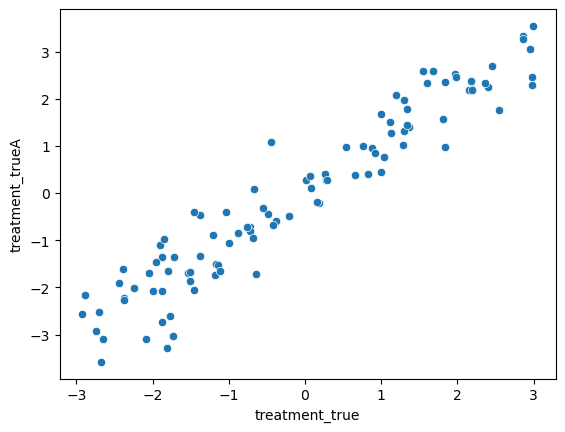

In [6]:
sns.scatterplot(x="treatment_true", y="treatment_trueA", data=df)

<Axes: xlabel='treatment_true', ylabel='treatment_randomA'>

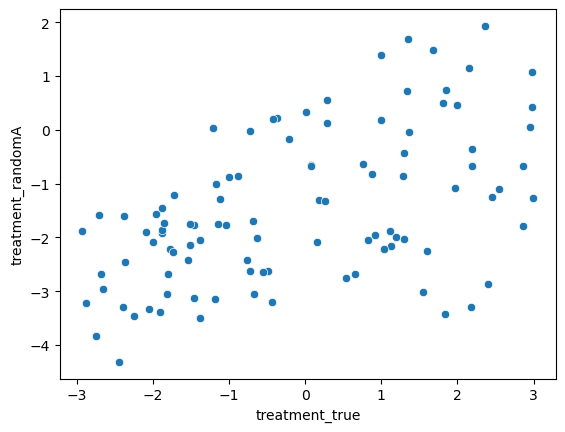

In [8]:
sns.scatterplot(x="treatment_true", y="treatment_randomA", data=df)

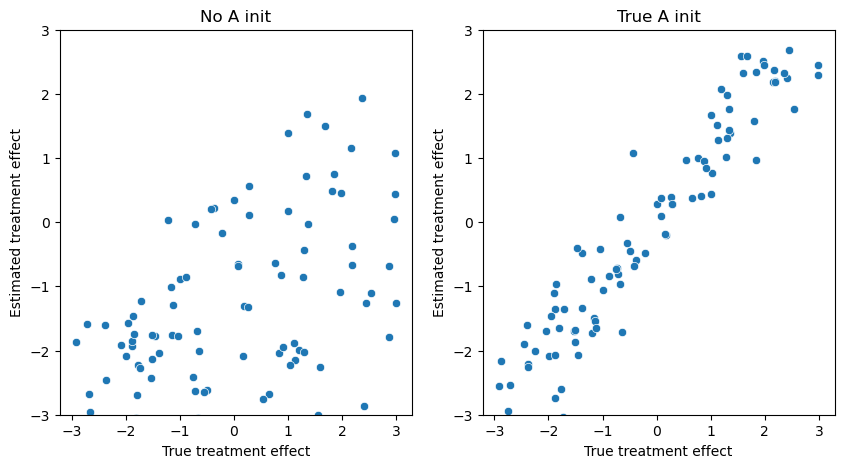

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x="treatment_true", y="treatment_randomA", data=df, ax=ax[0])
ax[0].set_title("No A init")
ax[0].set_xlabel("True treatment effect")
ax[0].set_ylabel("Estimated treatment effect")
ax[0].set_ylim(-3,3)
sns.scatterplot(x="treatment_true", y="treatment_trueA", data=df, ax=ax[1])
ax[1].set_title("True A init")
ax[1].set_xlabel("True treatment effect")
ax[1].set_ylabel("Estimated treatment effect")
ax[1].set_ylim(-3,3)
plt.show()




## Plot scores

<Axes: xlabel='f_score_randomA', ylabel='Count'>

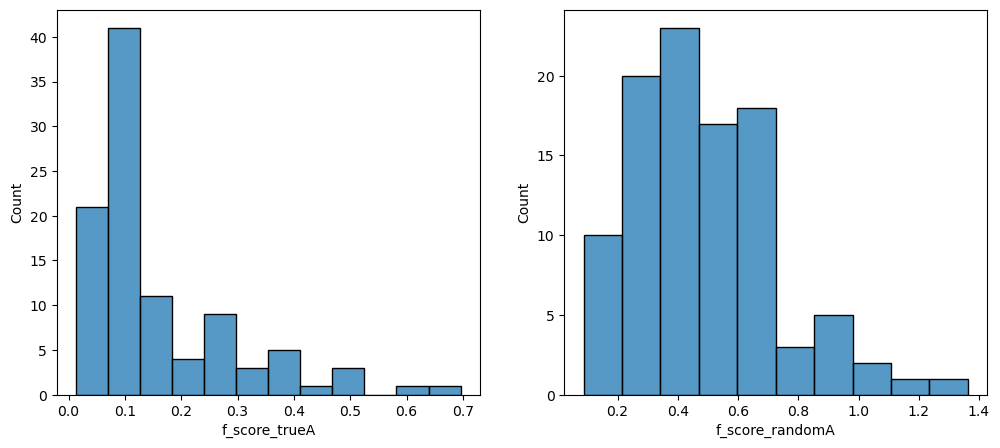

In [15]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.histplot(df, x = "f_score_trueA", ax = ax[0])
sns.histplot(df, x = "f_score_randomA", ax = ax[1])

<Axes: xlabel='mean_squared_error_randomA', ylabel='Count'>

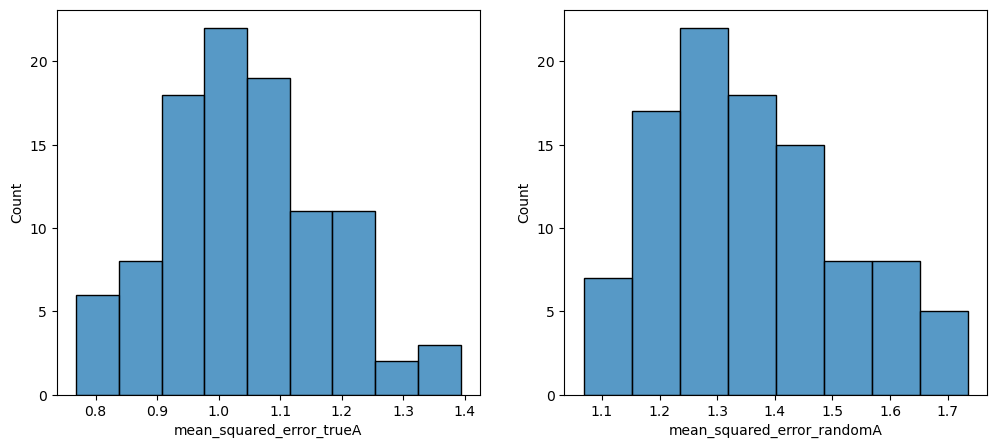

In [16]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.histplot(df, x = "mean_squared_error_trueA", ax = ax[0])
sns.histplot(df, x = "mean_squared_error_randomA", ax = ax[1])

# Plot one example

In [4]:
data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)}, noise_dict=  {"loc" : 0, "scale" : 0})
data.generate_data(n=n, J=J, I=I, random_state=0)
CausalVarEM_trueA = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=0, mode = "each")
CausalVarEM_trueA.fit(data.data_observed, J = J,
                  noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_trueA.A)
singals_estimation_VAR_trueA = CausalVarEM_trueA.Signals[:,best_perm]

CausalVarEM_randomA = CausalVarEM(update_sigma=False,   true_A= None, tol=1e-4, max_iter=200, random_seed=0, mode = "each")
CausalVarEM_randomA.fit(data.data_observed, J = J,
                  noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_randomA.A)
singals_estimation_VAR_randomA = CausalVarEM_randomA.Signals[:,best_perm]

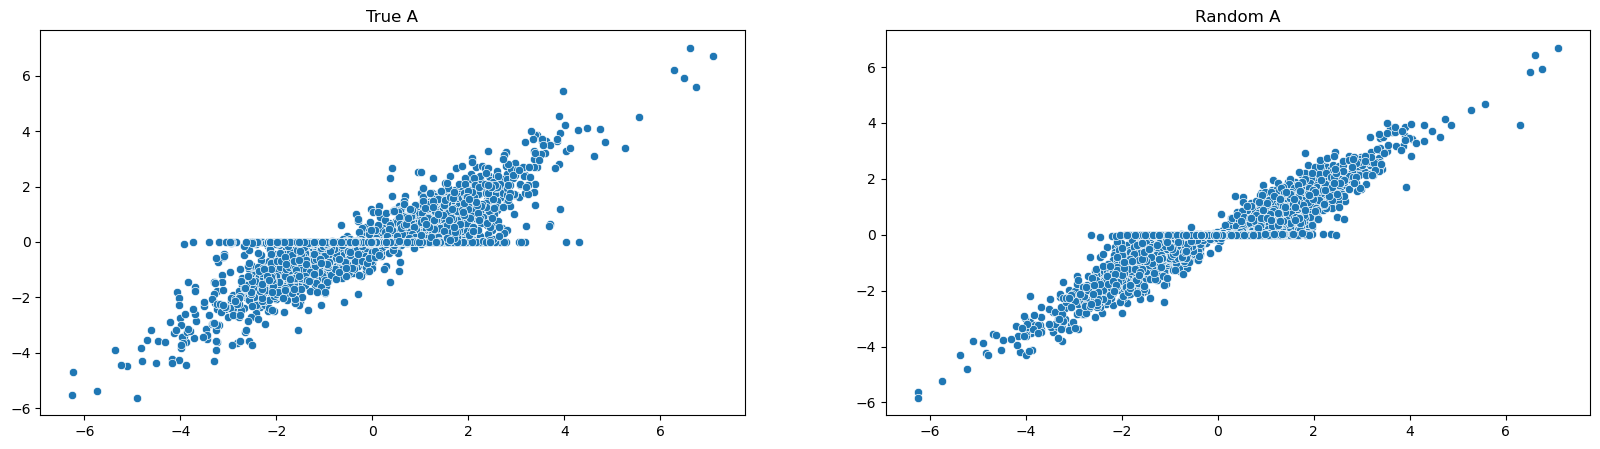

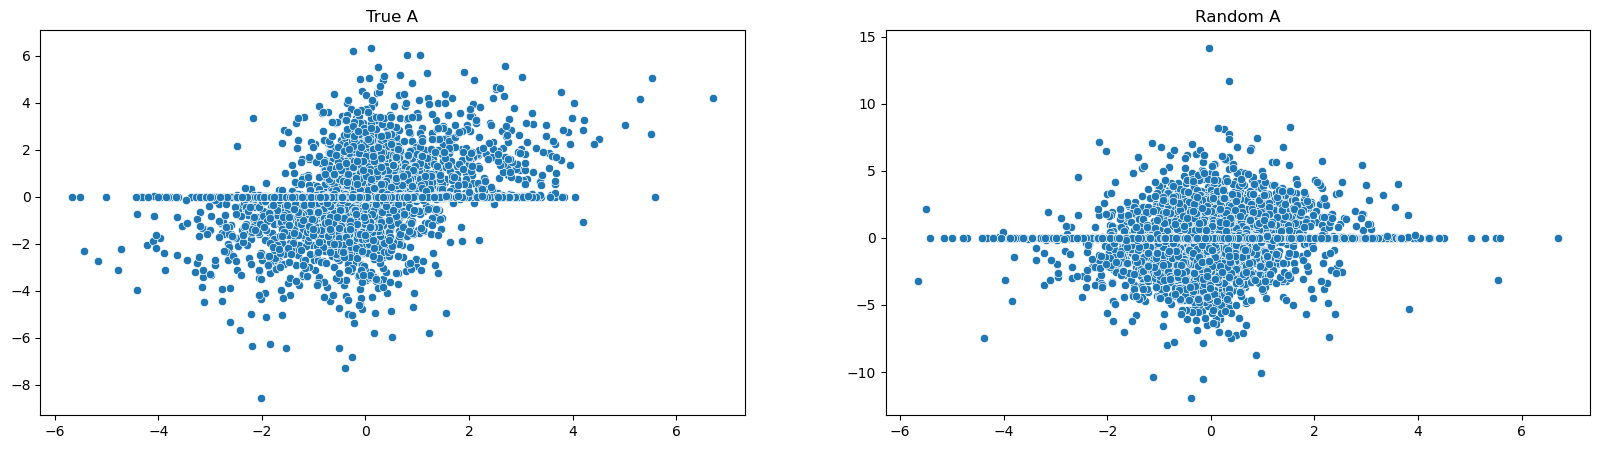

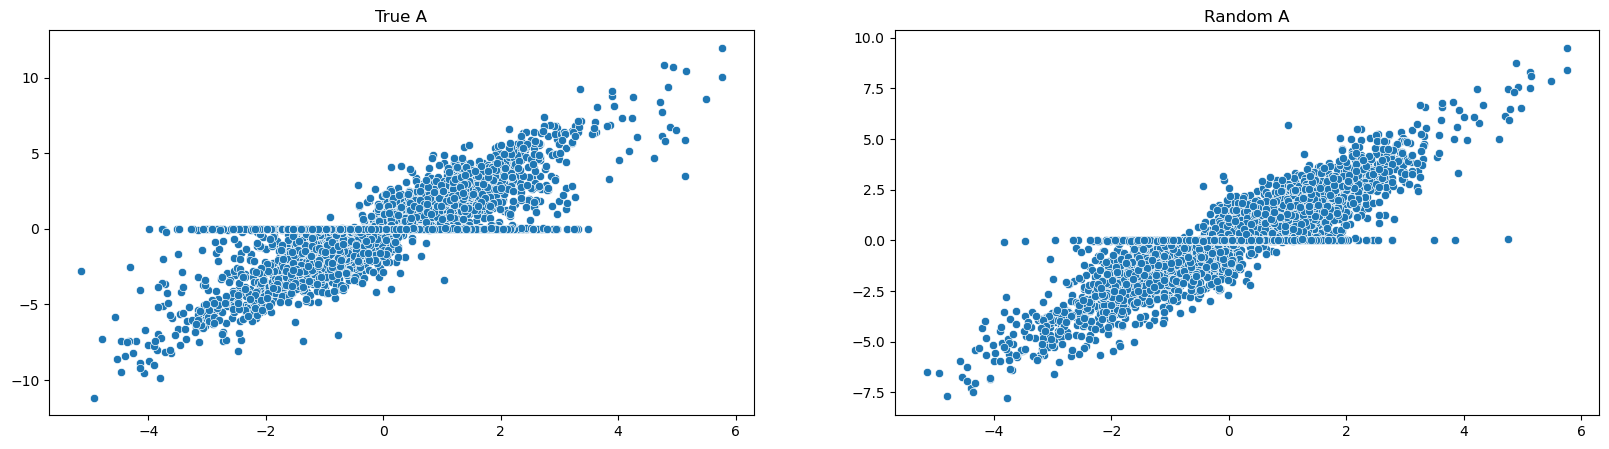

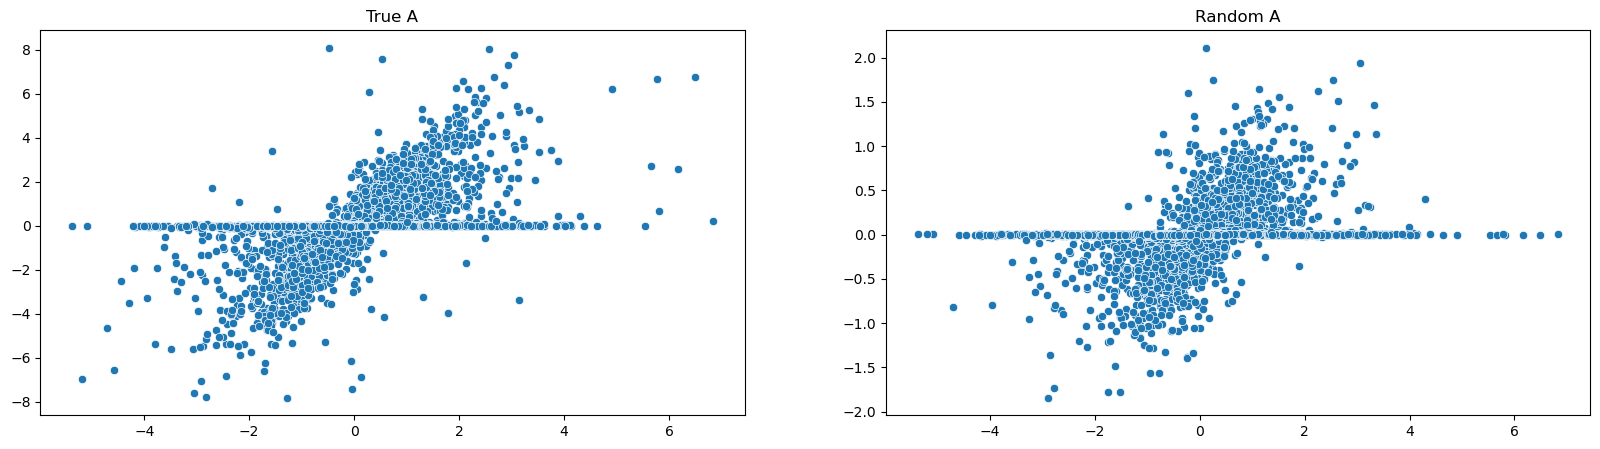

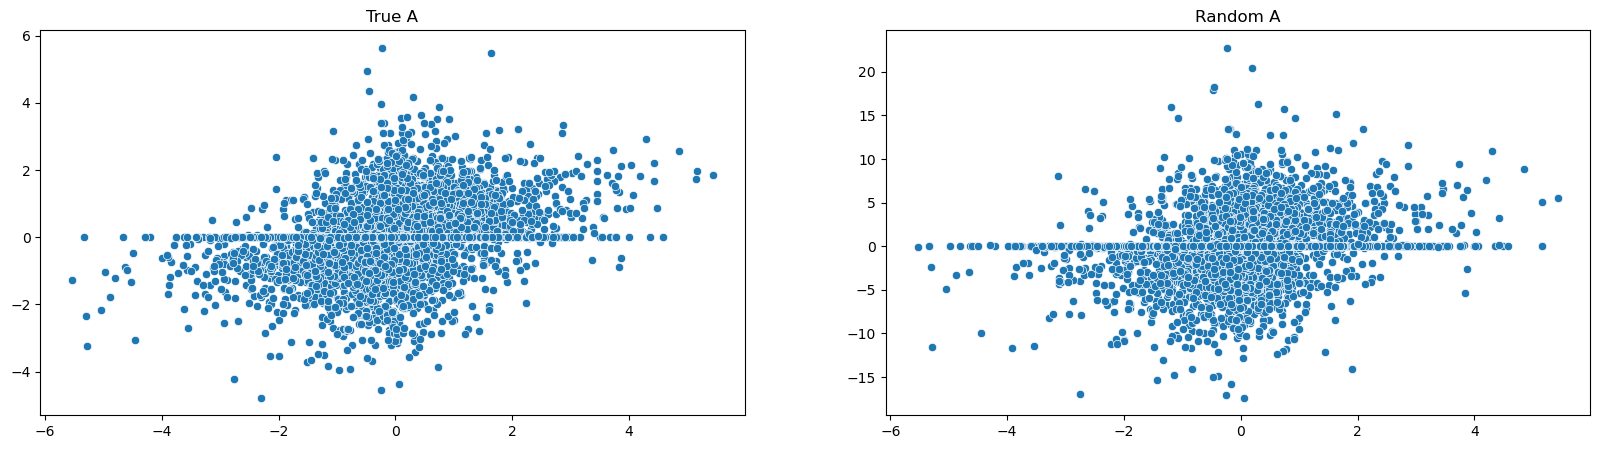

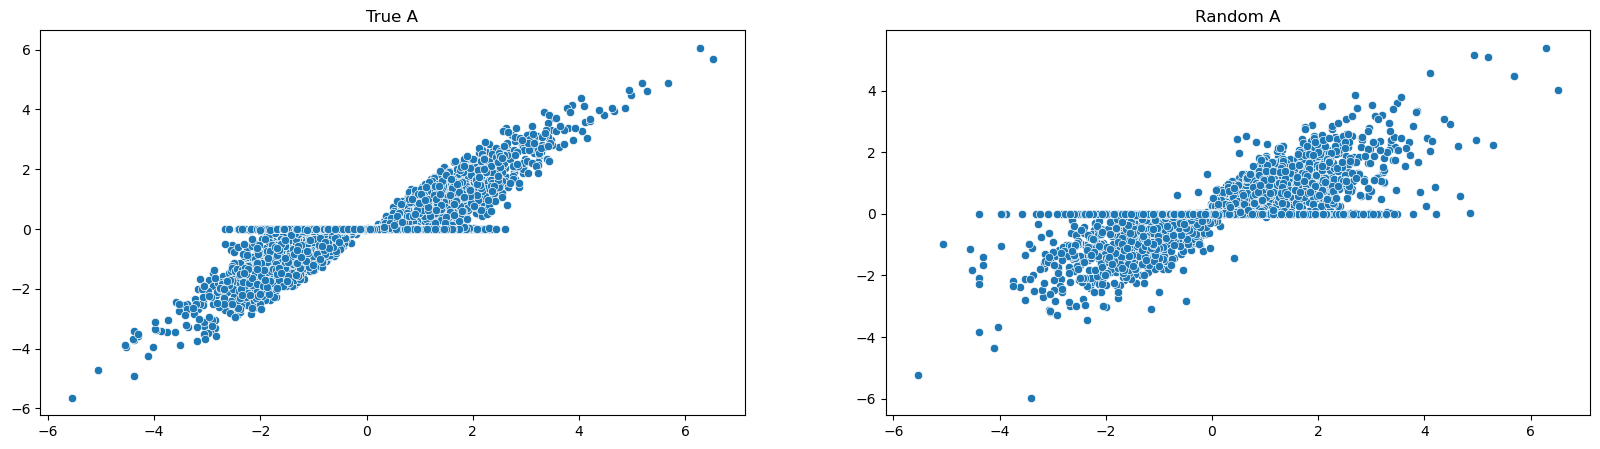

In [5]:
# plot true signals vs estimated signals
for i in range(J):
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    sns.scatterplot(x=data.signals[:,i], y=singals_estimation_VAR_trueA[:,i], ax=ax[0])
    ax[0].set_title("True A")
    sns.scatterplot(x=data.signals[:,i], y=singals_estimation_VAR_randomA[:,i], ax=ax[1])
    ax[1].set_title("Random A")
    plt.show()
